# Колоквиум 2018
## Машинска визија 2018/2019
### Андреј Јанчевски 151003

In [77]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob

In [4]:
def display_image(img):
    if len(img.shape) > 2:
        img_to_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(img_to_show)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

### Задача 1

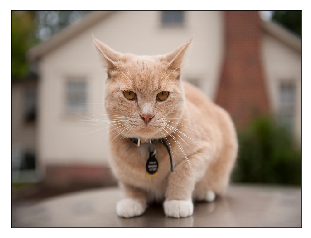

In [194]:
cats = []
for filename in glob.glob('cats/*'):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    cats.append(cv2.resize(img, (640, 480)))

display_image(cats[0])

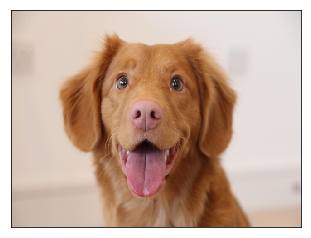

In [195]:
dogs = []
for filename in glob.glob('dogs/*'):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    dogs.append(cv2.resize(img, (640, 480)))

display_image(dogs[0])

In [196]:
train_images = cats[:7]
train_images.extend(dogs[:7])
train_labels = [1] * 7
train_labels.extend([0] * 7)
test_images = cats[7:]
test_images.extend(dogs[7:])
test_labels = [1] * 3
test_labels.extend([0] * 3)
print(train_labels)
print(test_labels)

[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0]


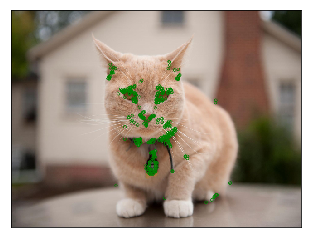

array([[  2, 176,  48, ...,  12, 135, 223],
       [124, 253, 186, ...,  59,  38, 171],
       [ 72, 208,  29, ..., 136, 129,  59],
       ...,
       [  9, 157, 111, ..., 174, 240, 249],
       [ 42, 213, 106, ...,  12, 252, 222],
       [ 49, 223, 121, ..., 153, 113, 185]], dtype=uint8)

In [197]:
orb_detect = cv2.ORB_create()
orb_extract = cv2.ORB_create()
FLANN_INDEX_LINEAR = 0
FLANN_INDEX_KDTREE = 1
FLANN_INDEX_KMEANS = 2
FLANN_INDEX_COMPOSITE = 3
FLANN_INDEX_KDTREE_SINGLE = 4
FLANN_INDEX_HIERARCHICAL = 5
FLANN_INDEX_LSH = 6
FLANN_INDEX_SAVED = 254
FLANN_INDEX_AUTOTUNED = 255
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)
flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
bow_kmeans_trainer = cv2.BOWKMeansTrainer(10)
extract_bow = cv2.BOWImgDescriptorExtractor(orb_extract, flann_matcher)


def get_keypoint_features(img, display_images=False):
    keypoints, descriptors = orb_extract.compute(img, orb_detect.detect(img))
    img_with_keypoints = np.zeros(img.shape, dtype='uint8')
    cv2.drawKeypoints(
        img, keypoints, img_with_keypoints, color=(0, 127, 0), flags=0)
    if display_images:
        display_image(img_with_keypoints)
    return keypoints, descriptors


get_keypoint_features(train_images[0], True)[1]

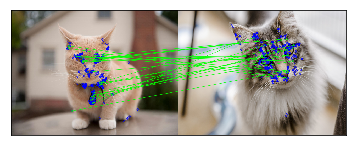

0.052

In [203]:
def match_keypoints(img1, img2, display_images=False):
    kp1, des1 = get_keypoint_features(img1)
    des1 = np.array(des1, dtype='float32')
    kp2, des2 = get_keypoint_features(img2)
    des2 = np.array(des2, dtype='float32')
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    matchesMask = [[0, 0] for i in range(len(matches))]
    good_matches = 0
    for i, match_pair in enumerate(matches):
        if len(match_pair) != 2:
            continue
        m, n = match_pair
        if m.distance < 0.8 * n.distance:
            matchesMask[i] = [1, 0]
            good_matches += 1
    draw_params = dict(
        matchColor=(0, 255, 0),
        singlePointColor=(255, 0, 0),
        matchesMask=matchesMask,
        flags=0)
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None,
                              **draw_params)
    if display_images:
        display_image(img3)
    return good_matches / len(matches)


match_keypoints(train_images[0], test_images[0], True)

In [204]:
def classify_image_by_keypoints(img):
    similarities = {}
    for i, train_image in enumerate(train_images):
        similarities[i] = match_keypoints(img, train_image)
    best_image = max(similarities.items(), key=lambda x: x[1])[0]
    return train_labels[best_image]


correct_predictions = 0
for i, test_image in enumerate(test_images):
    print("Classifying: " + str(i))
    prediction = classify_image_by_keypoints(test_image)
    if prediction == test_labels[i]:
        correct_predictions += 1

print("Accuracy: " + str(correct_predictions / len(test_images)))

Classifying: 0
Classifying: 1
Classifying: 2
Classifying: 3
Classifying: 4
Classifying: 5
Accuracy: 0.5


### Задача 2

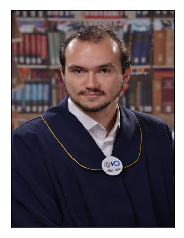

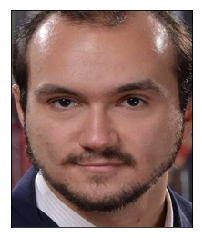

In [205]:
slika = cv2.imread("slika_zad3.jpg", cv2.IMREAD_COLOR)
slika = cv2.resize(slika, (480, 640))
display_image(slika)
lice = slika[80:320, 140:340]
display_image(lice)

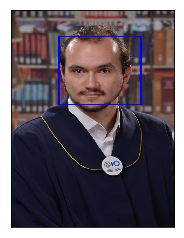

(140, 80)

In [206]:
def find_object_by_template_matching(img, template):
    res = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    template_width, template_height, _ = template.shape
    img_to_draw = np.copy(img)
    cv2.rectangle(img_to_draw, (max_loc[0], max_loc[1]),
                  (max_loc[0] + template_width, max_loc[1] + template_height),
                  (255, 0, 0), 3)
    display_image(img_to_draw)
    return max_loc


find_object_by_template_matching(slika, lice)

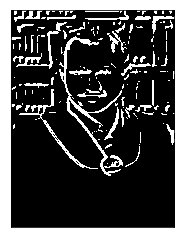

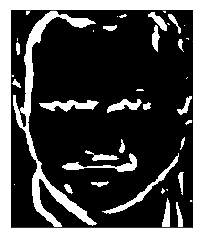

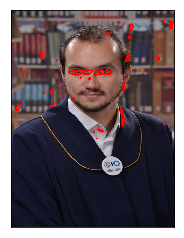

In [207]:
def get_edges(img, display_images=False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (11, 11), 0)
    sobel_h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_v = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    h_edges = cv2.filter2D(img_gray, ddepth=-1, kernel=sobel_h)
    v_edges = cv2.filter2D(img_gray, ddepth=-1, kernel=sobel_v)
    edges = cv2.bitwise_or(h_edges, v_edges)
    edges = cv2.GaussianBlur(edges, (3, 3), 0)
    #edges = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, edges = cv2.threshold(edges, 0, 255, cv2.THRESH_OTSU)
    if display_images:
        display_image(edges)
    return edges


def find_object_by_contours(img, obj):
    img_edges = get_edges(img, True)
    obj_edges = get_edges(obj, True)
    img_edges, img_contours, _ = cv2.findContours(img_edges, cv2.RETR_LIST,
                                                  cv2.CHAIN_APPROX_SIMPLE)
    obj_edges, obj_contours, _ = cv2.findContours(obj_edges, cv2.RETR_LIST,
                                                  cv2.CHAIN_APPROX_SIMPLE)
    img_best_contours = []
    for contour in obj_contours:
        img_best_contours.append(
            min(img_contours,
                key=lambda x: cv2.matchShapes(x, contour, 1, 0.0)))
    img_to_draw = np.copy(img)
    cv2.drawContours(img_to_draw, img_best_contours, -1, (0, 0, 255), 3)
    display_image(img_to_draw)


find_object_by_contours(slika, lice)

Подобри резултати се добија со template matching бидејќи објектот веќе постоеше во сликата а препознавањето со контури зависи од квалитетот на препознаените рабови.

### Задача 3

In [208]:
def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - (
        (avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - (
        (avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

In [209]:
def adaptive_histogram_equalization(img):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img[:, :, 0] = clahe.apply(img[:, :, 0])
    img[:, :, 1] = clahe.apply(img[:, :, 1])
    img[:, :, 2] = clahe.apply(img[:, :, 2])

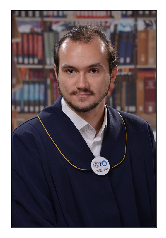

In [210]:
slika=cv2.imread("slika_zad3.jpg", cv2.IMREAD_COLOR)
display_image(slika)
slika_lab=cv2.cvtColor(slika, cv2.COLOR_BGR2LAB)

In [216]:
def getSkinPixelsHSV(img):
    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)
    face_mask_hue = cv2.inRange(h, 0, 20) + cv2.inRange(h, 160, 180)
    face_mask_saturation = cv2.inRange(s, 48, 150)
    face_mask_value = cv2.inRange(v, 140, 255)
    face_mask = cv2.bitwise_and(face_mask_hue, face_mask_saturation)
    face_mask = cv2.bitwise_and(face_mask, face_mask_value)
    face_mask = cv2.medianBlur(face_mask, 31)
    face_mask = cv2.morphologyEx(
        face_mask, op=cv2.MORPH_OPEN, kernel=(15, 15), iterations=2)
    h = cv2.bitwise_and(h, face_mask)
    s = cv2.bitwise_and(s, face_mask)
    v = cv2.bitwise_and(v, face_mask)
    img_hsv_masked = cv2.merge((h, s, v))
    img_result = cv2.cvtColor(np.uint8(img_hsv_masked), cv2.COLOR_HSV2BGR)
    return img_result

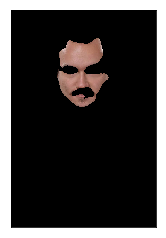

In [217]:
display_image(getSkinPixelsHSV(slika))

In [222]:
def getSkinPixelsLAB(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    print(cv2.minMaxLoc(a))
    print(cv2.minMaxLoc(b))
    print(cv2.minMaxLoc(l))
    face_mask_a = cv2.inRange(a, 140, 168)
    face_mask_b = cv2.inRange(b, 125, 189)
    face_mask_l = cv2.inRange(l, 115, 255)
    face_mask = cv2.bitwise_and(face_mask_a, face_mask_b)
    face_mask = cv2.bitwise_and(face_mask, face_mask_l)
    face_mask = cv2.medianBlur(face_mask, 31)
    face_mask = cv2.morphologyEx(
        face_mask, op=cv2.MORPH_OPEN, kernel=(15, 15), iterations=2)
    l = cv2.bitwise_and(l, face_mask)
    a = cv2.bitwise_and(a, face_mask)
    b = cv2.bitwise_and(b, face_mask)
    img_lab_masked = cv2.merge((l, a, b))
    img_result = cv2.cvtColor(np.uint8(img_lab_masked), cv2.COLOR_LAB2BGR)
    return img_result

(115.0, 169.0, (216, 638), (465, 270))
(80.0, 191.0, (414, 689), (257, 673))
(0.0, 255.0, (447, 227), (232, 155))


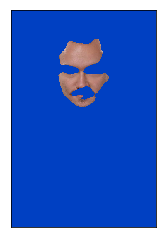

In [223]:
display_image(getSkinPixelsLAB(slika))

### Задача 4

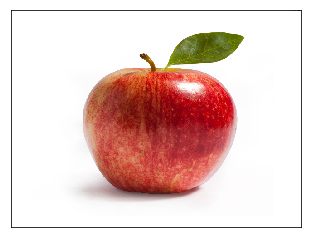

In [224]:
jabolko = cv2.imread("slika_zad4.jpg", cv2.IMREAD_COLOR)
jabolko = cv2.resize(jabolko, (640, 480))
display_image(jabolko)

175.0


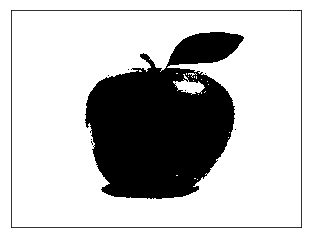

In [226]:
jabolko_gray=cv2.cvtColor(jabolko, cv2.COLOR_BGR2GRAY)
threshold, jabolko_thresholded = cv2.threshold(jabolko_gray, 0, 255, cv2.THRESH_OTSU)
print(threshold)
display_image(jabolko_thresholded)

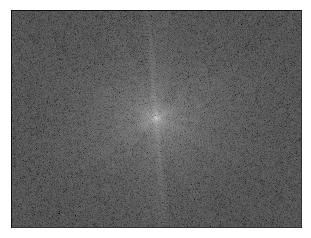

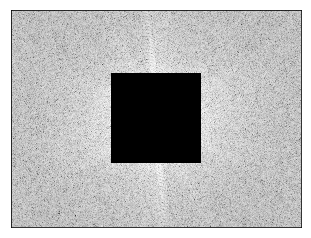

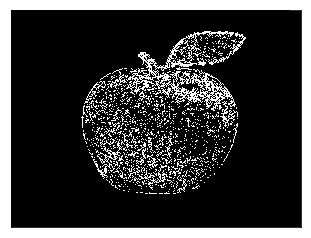

In [227]:
jabolko_fft = np.fft.fft2(jabolko_gray)
fshift = np.fft.fftshift(jabolko_fft)
magnitude_spectrum = 20 * np.log(np.abs(fshift))
display_image(magnitude_spectrum)
width, height = magnitude_spectrum.shape
filter_size = 100
magnitude_spectrum[(width // 2 - filter_size):(width // 2 + filter_size), (
    height // 2 - filter_size):(height // 2 + filter_size)] = 0
display_image(magnitude_spectrum)
fshift[(width // 2 - filter_size):(width // 2 + filter_size), (
    height // 2 - filter_size):(height // 2 + filter_size)] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
img_back = np.array(img_back, dtype='uint8')
threshold, jabolko_segmented_2 = cv2.threshold(img_back, 0, 255,
                                               cv2.THRESH_OTSU)
display_image(jabolko_segmented_2)